In [4]:
import warnings
warnings.filterwarnings("ignore")

## Prepare and load data!

In [5]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data

def Adata2Torch_data(adata): #提取adata中的features 和 edge_index, 即基因表达矩阵和邻接矩阵。
    G_df = adata.uns['Spatial_Net'].copy() #spoti and spotj之间的距离
    spots = np.array(adata.obs_names) #Spot_names
    spots_id_tran = dict(zip(spots, range(spots.shape[0]))) #对每个Spot进行编号
    G_df['Spot1'] = G_df['Spot1'].map(spots_id_tran) 
    G_df['Spot2'] = G_df['Spot2'].map(spots_id_tran) # 构建num_edges的过程。

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Spot1'], G_df['Spot2'])), shape=(adata.n_obs, adata.n_obs))
    # n_obs 是Spot个数；G是n_obs * n_obs的稀疏矩阵
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G) # edgeList就是构建出来的torch_geometric 中的num_edges
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))  # .todense()
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))  # .todense()
    return data
    # data的数据形式如下：Data(x=[3460, 33538], edge_index=[2, 23512])
    # 根据挑选出来的邻居构建邻接矩阵和基因表达数据。

def Spatial_Dis_Cal(adata, rad_dis=None, knn_dis=None, model='Radius', verbose=True):
    """\
    Calculate the spatial neighbor networks, as the distance between two spots.
    Parameters
    ----------
    adata:  AnnData object of scanpy package.
    rad_dis:  radius distance when model='Radius' 半径
    knn_dis:  The number of nearest neighbors when model='KNN' 邻居个数
    model:
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_dis. 
        When model=='KNN', the spot is connected to its first knn_dis nearest neighbors.
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """
    assert(model in ['Radius', 'KNN']) #断言语句，可以用来调试程序。
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial']) #Spot 空间坐标
    coor.index = adata.obs.index #df的index改为spot名称
    # coor.columns = ['imagerow', 'imagecol']
    coor.columns = ['Spatial_X', 'Spatial_Y'] #修改df的列名

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_dis).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        # Find the neighbors within a given radius of a point or points, 返回每个Spot在给定半径中的邻居个数及距离。
        # distances, indices的rows等于Spot的个数，即每个Spot都对应一个distance 和 index list.
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot]*indices[spot].shape[0], indices[spot], distances[spot]))) #每个spot的邻居编号；距离。
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=knn_dis+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot]*indices.shape[1],indices[spot,:], distances[spot,:])))

    KNN_df = pd.concat(KNN_list) #变为dataframe格式。
    KNN_df.columns = ['Spot1', 'Spot2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_spot_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), )) #构建一个词典，
    Spatial_Net['Spot1'] = Spatial_Net['Spot1'].map(id_spot_trans) #Spot1的编号，e.g. spot1出现几次，表明有几个邻居，在spot2里。
    Spatial_Net['Spot2'] = Spatial_Net['Spot2'].map(id_spot_trans) #Spot2的编号 spot1对应的邻居编号
    if verbose:
        print('The graph contains %d edges, %d spots.' %(Spatial_Net.shape[0], adata.n_obs)) #共多少条边
        print('%.4f neighbors per spot on average.' %(Spatial_Net.shape[0]/adata.n_obs)) #平均每个Spot多少条边 

    adata.uns['Spatial_Net'] = Spatial_Net

def Spatial_Dis_Draw(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Spot1'].shape[0] #共多少条边
    Mean_edge = Num_edge/adata.shape[0] #平均多少条边
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Spot1'])) 
    plot_df = plot_df/adata.shape[0]  #plot_df是一个概率list, 和为1.
    fig, ax = plt.subplots(figsize=[4,4],dpi=300)
    plt.ylabel('Percentage')
    plt.xlabel('Edge Numbers per Spot')
    plt.title('Number of Neighbors for Spots (Average=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df,color="#aa40fc",edgecolor="#f7b6d2",linewidth=2)

def Cal_Spatial_variable_genes(adata):
    import SpatialDE
    # counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
    counts = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    coor = pd.DataFrame(adata.obsm['spatial'], columns=['Spatial_X', 'Spatial_Y'], index=adata.obs_names)
    Spatial_var_genes = SpatialDE.run(coor, counts)
    Spatial_3000_var_genes = Spatial_var_genes["g"].values[0:3000]
    Spatial_3000_var_genes = pd.DataFrame(Spatial_3000_var_genes)
    all_genes = counts.columns.to_frame()
    for i in range(len(all_genes.values)):
        if all_genes.values[i] in Spatial_3000_var_genes.values:
            all_genes.values[i] =1
        else:
            all_genes.values[i] =0
    Spatial_highly_genes = all_genes.squeeze()
    adata.var["Spatial_highly_variable_genes"] = Spatial_highly_genes.astype(bool)

def DGI_loss_Draw(adata):
    import matplotlib.pyplot as plt
    if "Model_loss" not in adata.uns.keys():
        raise ValueError("Please Train Graph Deep Learning Model first!") #验证是否存在Spatial_Net
    Train_loss = adata.uns["Model_loss"]
    plt.style.use('default') #'seaborn-poster';seaborn-paper';'seaborn-deep''ggplot'
    plt.plot(Train_loss,label='Training loss',linewidth=2)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss of DGI model")
    plt.legend()
    plt.grid()

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


In [6]:
import scanpy as sc
adata=sc.read('/home/tengliu/Torch_pyG-Paper1/DLPFC_Comparison/SPGDL/Anndata/151673_Anndata.h5ad')

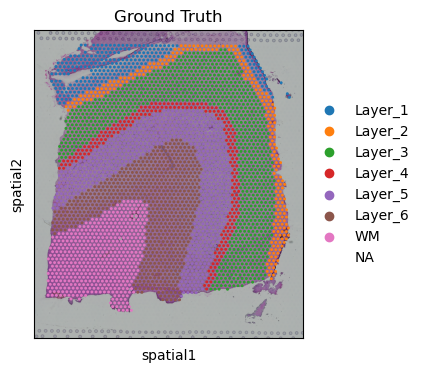

In [7]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

------Calculating spatial graph...
The graph contains 21124 edges, 3639 spots.
5.8049 neighbors per spot on average.


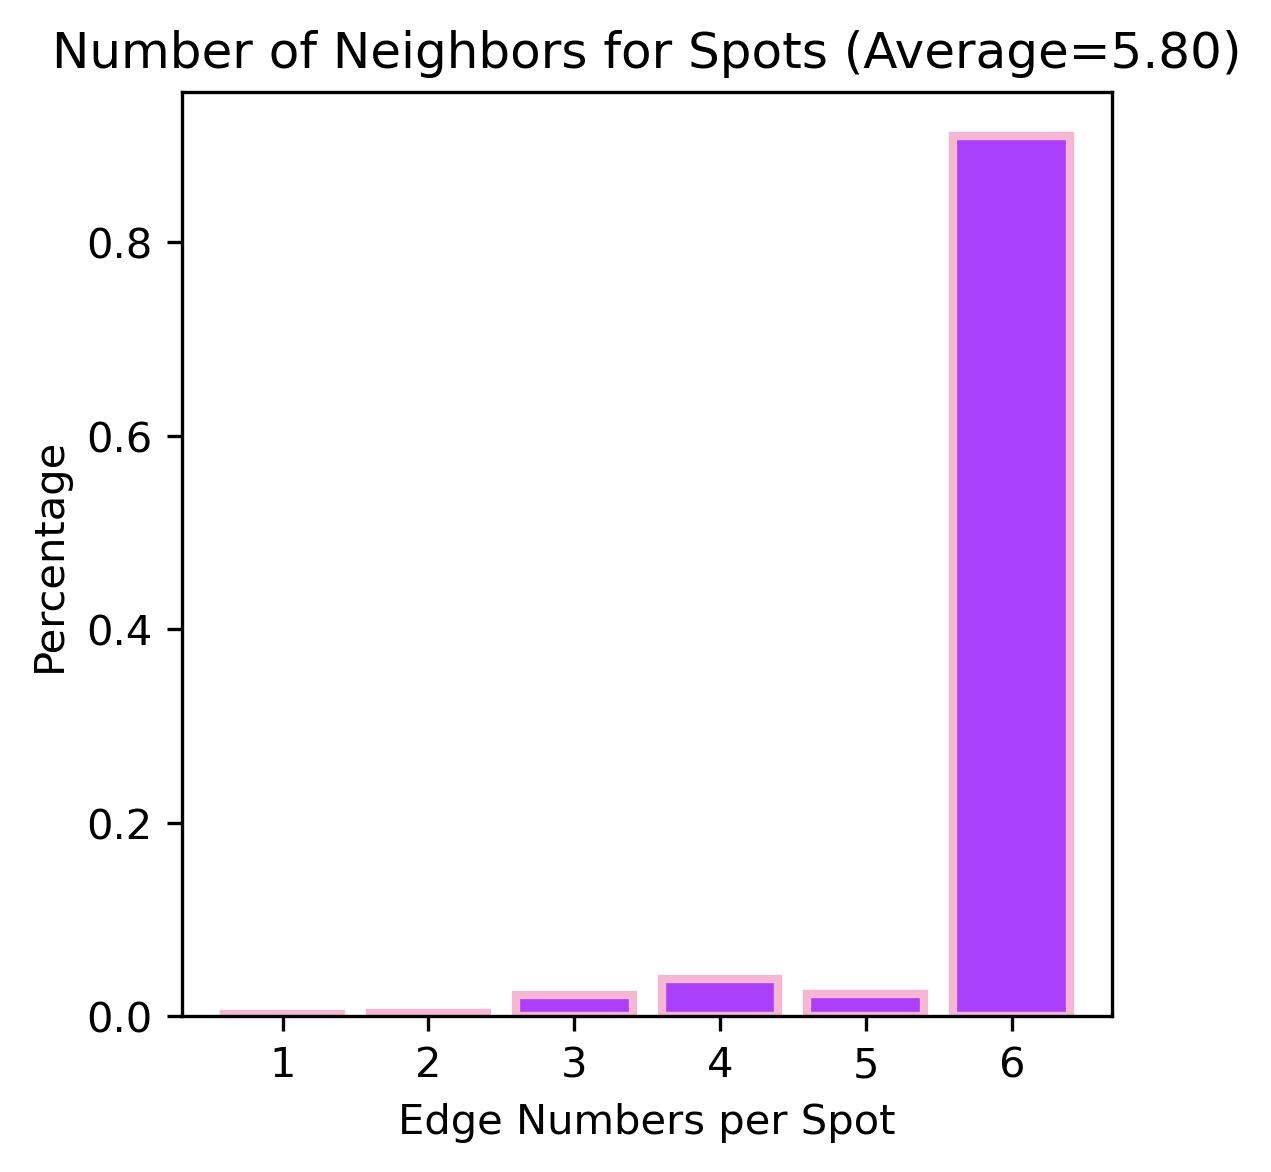

In [8]:
Spatial_Dis_Cal(adata,rad_dis=150)
Spatial_Dis_Draw(adata)

## Training process using 20 CNNs

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm #用来显示进度条,加在循环开头
import scipy.sparse as sp #存储/处理稀疏矩阵

from torch_geometric.utils import train_test_split_edges
import torch
import torch.backends.cudnn as cudnn
cudnn.deterministic = True #每次返回的卷积算法将是确定的，即默认算法
cudnn.benchmark = True #在每一个卷积层中测试 cuDNN 提供的所有卷积实现算法，然后选择最快的那个
import torch.nn.functional as F #激励函数 正向/反向
from torch_geometric.nn import VGAE # noqa (将不会发出警告)  ##2

from Paper2_functions import Adata2Torch_data

from torch_geometric.nn import ARMAConv,ChebConv,ClusterGCNConv,EGConv,FeaStConv,FiLMConv,\
GATv2Conv,GENConv,GeneralConv,GraphConv,HypergraphConv,LEConv,MFConv,ResGatedGraphConv,\
SAGEConv,SGConv,SuperGATConv,TAGConv,TransformerConv,GCNConv

Conv_list = [ARMAConv,ChebConv,ClusterGCNConv,EGConv,FeaStConv,FiLMConv,\
    GATv2Conv,GENConv,GeneralConv,GraphConv,HypergraphConv,LEConv,MFConv,ResGatedGraphConv,\
    SAGEConv,SGConv,SuperGATConv,TAGConv,TransformerConv,GCNConv]

# Conv_list = [TransformerConv,GCNConv]

adata_list = [_ for _ in range(len(Conv_list))]
adata_new = adata.copy() #backup the original anndata

for num_Conv in tqdm(range(0, len(Conv_list))):
    adata = adata_new.copy() #load the original anndata
    
    if Conv_list[num_Conv] == ChebConv:
        
        class VariationalEncoder(torch.nn.Module):
            def __init__(self, in_channels, out_channels):
                super(VariationalEncoder,self).__init__()
                self.conv1 = Conv_list[num_Conv](in_channels, 2 * out_channels,K=1)
                self.conv_mu = Conv_list[num_Conv](2 * out_channels, out_channels,K=1)
                self.conv_logstd = Conv_list[num_Conv](2 * out_channels, out_channels,K=1)

            def forward(self, x, edge_index):
                x = self.conv1(x, edge_index).relu()
                return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
            
    elif Conv_list[num_Conv] == GATv2Conv:
        
        class VariationalEncoder(torch.nn.Module):
            def __init__(self, in_channels, out_channels):
                super(VariationalEncoder,self).__init__()
                self.conv1 = Conv_list[num_Conv](in_channels, 2 * out_channels,concat=False,add_self_loops=False,bias=False)
                self.conv_mu = Conv_list[num_Conv](2 * out_channels, out_channels,concat=False,add_self_loops=False,bias=False)
                self.conv_logstd = Conv_list[num_Conv](2 * out_channels, out_channels,concat=False,add_self_loops=False,bias=False)

            def forward(self, x, edge_index):
                x = self.conv1(x, edge_index).relu()
                return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)        
    else:
        
        class VariationalEncoder(torch.nn.Module):
            def __init__(self, in_channels, out_channels):
                super(VariationalEncoder,self).__init__()
                self.conv1 = Conv_list[num_Conv](in_channels, 2 * out_channels)
                self.conv_mu = Conv_list[num_Conv](2 * out_channels, out_channels)
                self.conv_logstd = Conv_list[num_Conv](2 * out_channels, out_channels)

            def forward(self, x, edge_index):
                x = self.conv1(x, edge_index).relu()
                return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)            
        
        
    def VGAE_Train(adata, 
                hidden_dims=[512, 512],
                num_epochs=2000, 
                # lr=0.001, 
                lr=1e-6,
                key_added='SCGDL',
                gradient_clipping=5., 
                weight_decay=0.0001, 
                random_seed=0, 
                save_loss=True):
        """\
        Training graph attention auto-encoder.
        Parameters
        ----------
        adata: AnnData object of scanpy package.
        hidden_dims: The dimension of the encoder.
        n_epochs:Number of total epochs for training.
        lr: Learning rate for AdamOptimizer.
        key_added: The latent embeddings are saved in adata.obsm[key_added].
        gradient_clipping: Gradient Clipping. 梯度截断
        weight_decay: Weight decay for AdamOptimizer.
        save_loss: If True, the training loss is saved in adata.uns['SCGDL_loss'].
        save_reconst_exp: If True, the reconstructed expression profiles are saved in adata.layers['SCGDL_ReX'].
        device: See torch.device.

        Returns
        -------
        AnnData
        """
        # seed_everything() 默认为0 不进行seed
        seed=random_seed
        import random
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)


        adata.X = sp.csr_matrix(adata.X)

        if "Spatial_highly_variable_genes" in adata.var.columns:
            adata_Vars =  adata[:, adata.var['Spatial_highly_variable_genes']].copy()
            print('Input Size using Spatial_variable_genes: ', adata_Vars.shape)
        elif 'highly_variable' in adata.var.columns:
            adata_Vars =  adata[:, adata.var['highly_variable']].copy()
            print('Input Size using Highly_variable_genes: ', adata_Vars.shape)
        else:
            adata_Vars = adata.copy(deep=True)
            print('Input Size using All genes list: ', adata_Vars.shape) #输出多少个基因参与训练

        if 'Spatial_Net' not in adata.uns.keys():
            raise ValueError("Please Compute Spatial Network using Spatial_Dis_Cal function first!") #验证是否存在Spatial_Net

        ## Process the data
        data = Adata2Torch_data(adata_Vars) #Create torch.pyG data
        data = train_test_split_edges(data)
        
        ## Setting input and output channels
        hidden_dims = [data.x.shape[1]] + hidden_dims #hidden_dims = [3000,128,128]。
        in_channels, out_channels = hidden_dims[0], hidden_dims[2]
        
        ## Define the VGAE model
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VGAE(VariationalEncoder(in_channels, out_channels )).to(device)
        x = data.x.to(device)
        train_pos_edge_index = data.train_pos_edge_index.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        data = data.to(device)
        
        #Training process using VGAE models.
        import time
        start_time = time.time()
        loss_list = []
        for epoch in tqdm(range(1, num_epochs+1)):
            model.train()
            optimizer.zero_grad() #梯度清零
            z = model.encode(x, train_pos_edge_index) # encode调用encoder(上面定义)；同时调用reparametrize函数；最后返回z
            loss = model.recon_loss(z,train_pos_edge_index)
            loss = loss + (1 / data.num_nodes) * model.kl_loss() # num_nodes=3460 for 151676
            loss_list.append(float(loss))
            loss.backward()
            optimizer.step()
            # torch.nn.utils.clip_grad_norm_(VGAE_model.parameters(), gradient_clipping) #VGAE中暂时不用截断操作。
            # if ((epoch)%1000) == 0:
            #     print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, np.mean(loss_list)))
        end_time = time.time()
        print('Elapsed training time:{:.4f} seconds'.format((end_time-start_time)))   
        
        ## Evaluate/test the trained model. AP: 平均精确率；ROC：真正数占总正样本的比率   
        model.eval()
        z = model.encode(x, train_pos_edge_index)
        auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)          
        SCGDL_rep = z.to('cpu').detach().numpy()
        adata.obsm[key_added] = SCGDL_rep
        adata.uns["AUC"] = auc
        adata.uns["AP"] = ap
        adata.uns["Time"] = end_time-start_time
                    
        if save_loss:
            adata.uns['Model_loss'] = loss_list 

        return adata
    
    adata = VGAE_Train(adata)
    sc.pp.neighbors(adata, use_rep='SCGDL')
    sc.tl.umap(adata)
    ## Spatial clustering using latent representations in the embedding space    
    from sklearn.cluster import KMeans
    from sklearn.metrics.cluster import adjusted_rand_score
    num_cluster = 7  
    kmeans = KMeans(n_clusters=num_cluster, algorithm = "lloyd", random_state=0).fit(adata.obsm['SCGDL'])
    ## Load KMeans lables in adata.obs
    adata.obs["KMeans"] = adata.obs["Ground Truth"]   
    adata.obs["KMeans"] = kmeans.labels_    
    obs_df = adata.obs.dropna() ##过滤掉缺失值的行，即当前分类值为Nan，就把该行过滤掉。
    ARI = adjusted_rand_score(obs_df["KMeans"], obs_df['Ground Truth']) ## ARI 是从 包sklearn.metrics.cluster中导入的衡量标准
    print('Adjusted rand index = %.2f' %ARI)    
    adata.uns["ARI"] = ARI
    adata_list[num_Conv] = adata
import pickle
# file = open("./Results/151676_VGAE.pickle","wb")
file = open("./Results/151673_VGAE.pickle","wb")
pickle.dump(adata_list,file)
file.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:50<00:00, 39.32it/s]


Elapsed training time:50.8702 seconds


2022-12-21 11:12:25.136711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:12:25.570432: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-21 11:12:25.739043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-21 11:12:26.665139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Adjusted rand index = 0.29
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:41<00:00, 47.81it/s]


Elapsed training time:41.8346 seconds


 10%|█         | 2/20 [01:55<16:48, 56.00s/it]

Adjusted rand index = 0.23
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:55<00:00, 35.73it/s]


Elapsed training time:55.9754 seconds


 15%|█▌        | 3/20 [02:56<16:29, 58.22s/it]

Adjusted rand index = 0.30
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:42<00:00, 46.80it/s]


Elapsed training time:42.7373 seconds


 20%|██        | 4/20 [03:43<14:23, 53.98s/it]

Adjusted rand index = 0.21
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:22<00:00, 24.11it/s]


Elapsed training time:82.9544 seconds


 25%|██▌       | 5/20 [05:10<16:28, 65.92s/it]

Adjusted rand index = 0.37
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:23<00:00, 23.83it/s]


Elapsed training time:83.9330 seconds


 30%|███       | 6/20 [06:39<17:12, 73.75s/it]

Adjusted rand index = 0.21
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:57<00:00, 34.76it/s]


Elapsed training time:57.5385 seconds


 35%|███▌      | 7/20 [07:41<15:10, 70.03s/it]

Adjusted rand index = 0.38
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [02:16<00:00, 14.70it/s]


Elapsed training time:136.0717 seconds


 40%|████      | 8/20 [10:02<18:29, 92.47s/it]

Adjusted rand index = 0.37
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:09<00:00, 28.90it/s]


Elapsed training time:69.1995 seconds


 45%|████▌     | 9/20 [11:16<15:53, 86.64s/it]

Adjusted rand index = 0.17
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:47<00:00, 42.06it/s]


Elapsed training time:47.5545 seconds


 50%|█████     | 10/20 [12:08<12:41, 76.12s/it]

Adjusted rand index = 0.17
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:44<00:00, 44.88it/s]


Elapsed training time:44.5620 seconds


 55%|█████▌    | 11/20 [12:57<10:10, 67.81s/it]

Adjusted rand index = 0.37
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:57<00:00, 34.97it/s]


Elapsed training time:57.1943 seconds


 60%|██████    | 12/20 [14:00<08:49, 66.16s/it]

Adjusted rand index = 0.13
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:47<00:00, 18.65it/s]


Elapsed training time:107.2460 seconds


 65%|██████▌   | 13/20 [15:52<09:21, 80.25s/it]

Adjusted rand index = 0.03
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:11<00:00, 28.11it/s]


Elapsed training time:71.1579 seconds


 70%|███████   | 14/20 [17:08<07:54, 79.01s/it]

Adjusted rand index = 0.26
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:47<00:00, 41.72it/s]


Elapsed training time:47.9445 seconds


 75%|███████▌  | 15/20 [18:01<05:55, 71.12s/it]

Adjusted rand index = 0.47
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:48<00:00, 41.08it/s]


Elapsed training time:48.6910 seconds


 80%|████████  | 16/20 [18:55<04:23, 65.85s/it]

Adjusted rand index = 0.43
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:42<00:00, 19.58it/s]


Elapsed training time:102.1487 seconds


 85%|████████▌ | 17/20 [20:41<03:54, 78.09s/it]

Adjusted rand index = 0.38
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:29<00:00, 22.39it/s]


Elapsed training time:89.3432 seconds


 90%|█████████ | 18/20 [22:15<02:45, 82.87s/it]

Adjusted rand index = 0.50
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [01:17<00:00, 25.78it/s]


Elapsed training time:77.5756 seconds


 95%|█████████▌| 19/20 [23:38<01:22, 82.72s/it]

Adjusted rand index = 0.49
Input Size using Highly_variable_genes:  (3639, 3000)


100%|██████████| 2000/2000 [00:47<00:00, 42.55it/s]


Elapsed training time:47.0032 seconds


100%|██████████| 20/20 [24:30<00:00, 73.50s/it]

Adjusted rand index = 0.36


In [ ]:
# lr = 0.001:0.25 0.33
# lr = 1e-6 1000 epoch:0.33 0.34
# lr = 1e-6 2000 epoch:0.35 0.33

In [ ]:
# if section_id in ['151669', '151670', '151671', '151672']:
#     n_components = 5
# else:
#     n_components = 7

## Save and load anndata list

In [ ]:
## Pickle the results to a file
import pickle
file = open("./Results/151676_VGAE.pickle","wb")
pickle.dump(adata_list,file)
file.close()

In [ ]:
## reload the results to anndata
import pickle
with open("./Results/151676_VGAE.pickle","rb") as file:
    adata_list = pickle.load(file)

adata_list

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["KMeans", "Ground Truth"],legend_loc='on data', 
            legend_fontsize=12,legend_fontoutline=2,frameon=False, title=["KMeans" + ' (ARI=%.2f)'%ARI, "Ground Truth"])